In [1]:
# Imports from the Python standard library
from io import StringIO
from typing import Iterable
import numpy as np
import matplotlib.pyplot as plt

# Imports from the comp chem ecosystem
from openff.units import Quantity, unit
from openmm import unit as openmm_unit
#from pdbfixer import PDBFixer

# New topology imports
from openff.interchange import Interchange

# Imports from the toolkit
from rdkit import Chem
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper
from openff.toolkit.utils import get_data_file_path

# Imports from OpenFF
import openff.nagl
from openff.nagl import GNNModel 
from openff.nagl_models import list_available_nagl_models
# If ypu want a diff toolkit wrapper check out https://docs.openforcefield.org/projects/nagl/en/latest/toolkit_wrappers.html

import pandas as pd
import nglview
import time
import mdtraj
import yaml
import os

### Build your molecules from SMILES strings

In [2]:
list_available_nagl_models()
model_path = '/home/julianne/miniconda3/envs/openff/lib/python3.11/site-packages/openff/nagl_models/models/openff-gnn-am1bcc-0.1.0-rc.1.pt'
model = GNNModel.load(model_path)

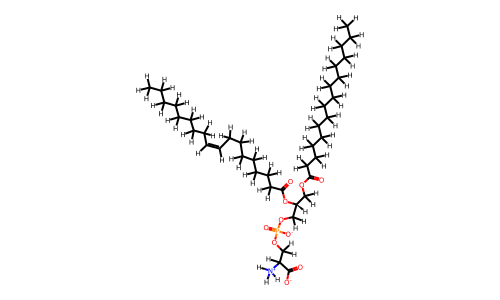

In [3]:
lipid = Molecule.from_smiles("[C@](COP(=O)([O-])OCC(C(=O)([O-]))[N+](H)(H)H)([H])(OC(CCCCCCC/C=C\CCCCCCCC)=O)COC(CCCCCCCCCCCCCCC)=O", allow_undefined_stereo=True)
lipid.generate_conformers()
lipid.visualize()

# #smiles string from : https://www.lipidmaps.org/databases/lmsd/


In [4]:
model.compute_property(lipid)

lipid.name = "POPS"
for i, atom in enumerate(lipid.atoms, 3):
    atom.metadata["residue_name"] = "POPS"
lipid.generate_unique_atom_names() #option to use (suffix = 'x')


topology = Topology.from_molecules(
    [lipid]
)

forcefield = ForceField("openff-2.1.0.offxml")
from openff.interchange import Interchange

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
)
interchange

lipid.to_file('lipid.pdb', file_format = 'pdb')
interchange.to_top("lipid.top")
interchange.to_gro("lipid.gro")

/home/julianne/miniconda3/envs/openff/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


In [5]:
m = mda.Universe('lipid.gro')

atom_data = []
for atom in m.atoms:
    atom_info = {
        'Atom Index': atom.index + 1,
        'Atom Name': atom.name,
        'Atom Type': atom.type,
        'Residue Name': atom.resname,
        'Residue Index': atom.resid,
        'Segment ID': atom.segid
    }
    atom_data.append(atom_info)

atom_df = pd.DataFrame(atom_data)

print(atom_df)

output_file = 'atom_info_mapping_file.txt'
atom_df.to_csv(output_file, sep='\t', index=False)

print(f"DataFrame has been exported to '{output_file}'")

#this atom dataframe will be important when building a mapping file for your system

     Atom Index Atom Name Atom Type Residue Name  Residue Index Segment ID
0             1       C1x         C         POPS              1     SYSTEM
1             2       C2x         C         POPS              1     SYSTEM
2             3       O1x         O         POPS              1     SYSTEM
3             4       P1x         P         POPS              1     SYSTEM
4             5       O2x         O         POPS              1     SYSTEM
..          ...       ...       ...          ...            ...        ...
122         123      H71x         H         POPS              1     SYSTEM
123         124      H72x         H         POPS              1     SYSTEM
124         125      H73x         H         POPS              1     SYSTEM
125         126      H74x         H         POPS              1     SYSTEM
126         127      H75x         H         POPS              1     SYSTEM

[127 rows x 6 columns]
DataFrame has been exported to 'atom_info_mapping_file.txt'


In [6]:
model_path = '/home/julianne/Desktop/OpenFFLipid/POPS/lipid.pdb' #change model path

view = nglview.show_structure_file(model_path)
view

NGLWidget()

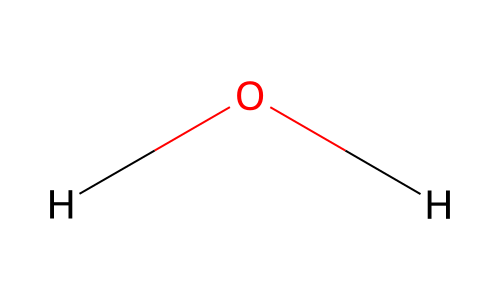

In [7]:
water = Molecule.from_smiles("O")
water.generate_conformers()
water.visualize()

In [8]:
model.compute_property(water)

forcefield = ForceField("openff-2.1.0.offxml")

water.name = "TIP3P"

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = "TIP3P"
water.generate_unique_atom_names() 


interchange = forcefield.create_interchange(water.to_topology())

# PDB structure for Packmol
interchange.to_pdb("water.pdb")
interchange.to_top("water.top")
interchange.to_gro("water.gro")

/home/julianne/miniconda3/envs/openff/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


### The lipids structural orientation is not acceptable when packing lipids into a bilayer. Use gromacs to create an index file for a head atom, and use a pulling script in gromacs to straighten out the lipid

The nitrogen from POPC is used here since it is the furthest core atom
For more complicated structures, you can specificy multiple atoms and link them (reference 'specific_pull.mdp' in this repo)\
The following steps are executed locally in gromacs

> gmx make_ndx -f lipid.gro -o N1x.ndx

Input for this index (atom 13 is Nitrogen) This will change if your smiles string is different from the one above. This will create an atom group for the Nitrogen 

> a 13\
> name 3 N1x\
> q

After the index file is created, verify pull_nvt.mdp script and run pulling simulation 

> gmx grompp -f pull_nvt.mdp -c lipid.gro -p lipid.top -n N1x.ndx -o pull.tpr -maxwarn 1  \
> gmx mdrun -deffnm pull

The returned pull.gro returns the last frame of the trajectory. Convert this to a pdb to visualize.

> gmx editconf -f pull.gro -o POPS.pdb 

In [9]:
model_path = '/home/julianne/Desktop/OpenFFLipid/POPS/POPS.pdb' #change model path

view = nglview.show_structure_file(model_path)
view


NGLWidget()

## Estimate dimensions of box for packmol 

In [10]:
u = mda.Universe('POPS.pdb')

head_group = u.select_atoms('name N1x') #select atom in head group, in this case Nitrogen
tail_group = u.select_atoms('name C23x') #select atom in tail group, in this case last carbon in unsaturated tail

distance = distances.distance_array(head_group.positions,tail_group.positions)
print("Length of lipid from head group to tail group is:\n","~",round(distance[0][0],2),'Angstrom') 

Length of lipid from head group to tail group is:
 ~ 30.67 Angstrom


/home/julianne/miniconda3/envs/openff/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


Estimate the desired number of lipids or membrane size in x y diresction when area per lipid is roughly known \
$ N_I = \frac{2 L_x L_y}{a_I}$  \
where $N_I$ = total # lipids\
$L_x , L_y$ = lateral box dimensions\
$a_I$ = area per lipid in units $Å^{2}$

In [11]:
N = 128
a = 65
L = np.sqrt(N * a /2)
print(round(L,0), "angstrom dimensions for Length")

64.0 angstrom dimensions for Length


Modify bilayer-comment.inp file if necessary with propper length and atom names 
> packmol < bilayer-comment.inp

In [12]:
model_path = '/home/julianne/Desktop/OpenFFLipid/POPS/bilayer.pdb' #change model path

view = nglview.show_structure_file(model_path)
view

NGLWidget()

In [13]:
# Define ff versions
forcefield = ForceField("openff-2.1.0.offxml")

# Atom count
topology = Topology.from_molecules(5120 * [water] + 128 * [lipid])

# Packmol bilayer to parametrize
path = mdtraj.load('bilayer.pdb')

# Topology designation given Packmol coordinates
topology.set_positions(path.xyz[0] * unit.nanometer)
topology.box_vectors = [8.0,8.0,9.8] * unit.nanometer

water.name = "TIP3P"
lipid.name = "POPC"

for i, atom in enumerate(lipid.atoms, 3):
    atom.metadata["residue_name"] = "POPC"
    lipid.generate_conformers()
    lipid.generate_unique_atom_names() #(suffix = "x") this suffix is default 
for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = "TIP3P"
    water.generate_conformers()
    water.generate_unique_atom_names() #(suffix = "w")

interchange = forcefield.create_interchange(topology)

interchange.to_gromacs(prefix = "bilayer")

change bilayer.top to topol.top

Energy minimization 
> gmx grompp -f min.mdp -p topol.top -c bilayer.gro -o min.tpr\
> gmx mdrun -deffnm min

NVT
> gmx grompp -p topol.top -f nvt.mdp -c min.gro -o nvt.tpr\
> gmx mdrun -deffnm nvt

NPT
> gmx grompp -f npt.mdp -p topol.top -c nvt.gro -o npt.tpr -maxwarn 1\
> gmx mdrun -deffnm npt

MD production run
> gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr\
> gmx mdrun -deffnm md\
> gmx mdrun -deffnm md -cpi md.cpt

### Building a Mapping file 

In [91]:
atom_df

,Atom Index,Atom Name,Atom Type,Residue Name,Residue Index,Segment ID
0,1,C1x,C,POPS,1,SYSTEM
1,2,O1x,O,POPS,1,SYSTEM
2,3,O2x,O,POPS,1,SYSTEM
3,4,C2x,C,POPS,1,SYSTEM
4,5,H1x,H,POPS,1,SYSTEM
...,...,...,...,...,...,...
123,124,H72x,H,POPS,1,SYSTEM
124,125,H73x,H,POPS,1,SYSTEM
125,126,H74x,H,POPS,1,SYSTEM
126,127,H75x,H,POPS,1,SYSTEM


In [84]:
#create a dictionary of atom index and atom name as key
atom_df_indexed = atom_df.set_index('Atom Index')
atom_index_name_dict = atom_df_indexed['Atom Name'].to_dict()

In [89]:
with open('mappingPOPSnumbered.yaml', 'r') as yaml_file:
    yaml_data = yaml_file.read()

# Write the YAML data into a text file
with open('yaml_data.txt', 'w') as txt_file:
    txt_file.write(yaml_data)


In [90]:
# Read the content of the YAML file and remove any indentation 
with open('yaml_data.txt', 'r') as file:
    lines = file.readlines()

modified_lines = [line.lstrip() for line in lines]

with open('yaml_data.txt', 'w') as file:
    file.writelines(modified_lines)

# Open the no-indentation yaml file and 
with open('yaml_data.txt', 'r') as file:
    lines = file.readlines()

# Define a regular expression pattern to match atom indexes.  
# This regular expression pattern will match sequences of digits in a string, but only if they are standalone words, 
# not part of a larger word.
atom_index_pattern = re.compile(r'\b(\d+)\b')

# Replace the dictionary indexes with their corresponding keys
modified_lines = []
for line in lines:
    modified_line = line
    # Find all matches of atom indexes in the line
    matches = atom_index_pattern.findall(line)
    for match in matches:
        atom_number = int(match)
        if atom_number in atom_index_name_dict:
            atom_key = atom_index_name_dict[atom_number]
            modified_line = modified_line.replace(match, atom_key)
    # Check if the line starts with "ATOMNAME" or "FRAGMENT" and indent by two spaces
    if modified_line.startswith("ATOMNAME") or modified_line.startswith("FRAGMENT"):
        modified_line = "  " + modified_line
    modified_lines.append(modified_line)

# Write the modified content back to the text file
with open('yaml_data.txt', 'w') as file:
    file.writelines(modified_lines)

os.rename('yaml_data.txt', 'MappingPOPSsage_smiles.yaml')

Add a comment to the first line of the mapping file and insert the smiles string so that it may be used for others